In [1]:
import os
os.chdir('/Users/burkelawlor/Repos/fmri-animation')

import numpy as np
import pandas as pd
from alive_progress import alive_bar
import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from nilearn import image, plotting, masking
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from nilearn.maskers import NiftiMasker

In [2]:
# Load the 4D fMRI data
fmri_file = 'data/sub-01_ses-V1_task-S1_run-03_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold.nii.gz'
fmri_img = nib.load(fmri_file)
print(fmri_img.shape)
print(fmri_img.affine)

(97, 115, 97, 569)
[[   2.     0.     0.   -96.5]
 [   0.     2.     0.  -132.5]
 [   0.     0.     2.   -78.5]
 [   0.     0.     0.     1. ]]


In [3]:
# Load network parcellations
ntwk_file = 'data/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii'
ntwk_img = nib.load(ntwk_file)
print(ntwk_img.shape)
print(ntwk_img.affine)

(91, 109, 91)
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


In [33]:
# Resample the network parcellations to the fMRI data
ntwk_img_resampled = image.resample_img(ntwk_img, target_affine=ntwk_img.affine, target_shape=fmri_img.shape[:3]) # Resample the shape but not the affine to preserve the network labels
print(ntwk_img_resampled.shape)
print(ntwk_img_resampled.affine)

(97, 115, 97)
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


In [41]:
print('Networks are labeled 1-100')
print(pd.Series(ntwk_img_resampled.get_fdata().reshape(-1)).value_counts())

Networks are labeled 1-100
0.0     950003
80.0      3291
32.0      2593
46.0      2591
41.0      2511
         ...  
19.0       547
37.0       531
11.0       530
99.0       496
63.0       382
Name: count, Length: 101, dtype: int64


Example with one network

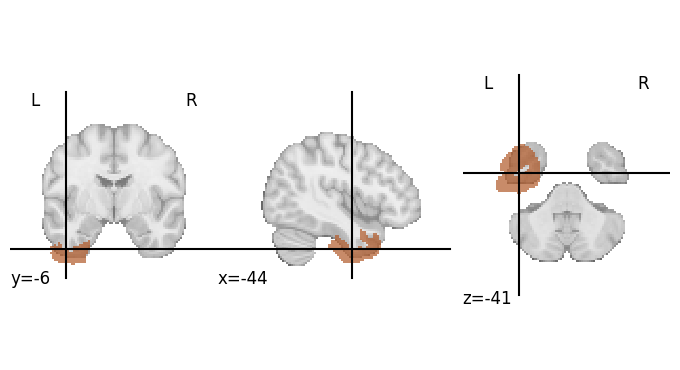

[ 6.31429405e-01 -4.86670389e-02 -6.74130997e-01 -1.53663462e+00
 -2.65748372e+00 -3.41456044e+00 -3.54924433e+00 -3.63746016e+00
 -3.99171164e+00 -4.29457063e+00 -1.92723686e+00 -1.59892752e+00
 -2.40694735e+00 -2.32754742e+00  4.32444730e+00  5.44739977e+00
  5.02392623e+00  4.34296664e+00  2.37762057e+00 -8.58375410e-01
  4.96712441e+00  6.16448543e+00  6.43308148e+00  7.83770486e+00
  8.13752181e+00 -2.08228636e-01 -7.75226397e+00 -1.85195388e+01
 -1.52687152e+01 -1.18083071e+01 -1.53841089e+00  5.77620844e+00
  7.58472949e+00  6.13169309e+00  5.12197775e+00  6.58514801e-01
  4.10122508e+00  3.03045201e+00  1.43080027e+00 -5.91924040e-01
 -2.52903085e+00 -3.59248440e+00 -3.21516690e+00 -2.05554283e+00
 -4.34685795e+00 -6.45302353e+00 -8.23368394e+00 -1.05059134e+01
 -5.79401688e+00 -1.52419567e+00  2.12378768e+00 -1.77377992e+00
 -1.12091307e+01 -2.57944485e+01 -1.70525454e+01 -3.53433824e+00
 -1.39154089e+00 -4.15154228e+00 -1.08593467e+01 -4.26220512e+00
  1.57522512e+00  5.10878

In [95]:
network = 80

# Create a mask for the network
mask = (ntwk_img_resampled.get_fdata() == network).astype(float)
mask_img = nib.Nifti1Image(mask, fmri_img.affine)
plotting.plot_roi(mask_img, cmap='Paired')
plotting.show()

# Apply the mask to the fMRI data
fmri_network_img = masking.apply_mask(fmri_img, mask_img)

# Calculate the mean intensity of the network for each timepoint
mean_intensity_timeseries = fmri_network_img.mean(axis=1)
print(mean_intensity_timeseries)

Run for all networks

In [106]:
result_list = []

with alive_bar(100, force_tty=True) as bar:
    for network in range(1, 101):
        # Create a mask for the network
        mask = (ntwk_img_resampled.get_fdata() == network).astype(float)
        mask_img = nib.Nifti1Image(mask, fmri_img.affine)

        # Apply the mask to the fMRI data
        fmri_network_img = masking.apply_mask(fmri_img, mask_img)

        # Calculate the mean intensity of the network for each timepoint
        mean_intensity_timeseries = fmri_network_img.mean(axis=1)

        # Append the result to the result list
        result_list.append({'network_label': network, 'mean_intensity_timeseries': mean_intensity_timeseries})
        bar()

mean_intensity_timeseries_df = pd.DataFrame(result_list)
mean_intensity_timeseries_df.to_csv('data/Schaefer2018_100Parcels_7Networks_order_mean_intensity_timeseries.csv', index=False)

|████████████████████████████████████████| 100/100 [100%] in 14:22.0 (0.12/s)   


**Plot the mean intensities of each network over time**

Split them up by genreal network to make it more managable to view.

Vis


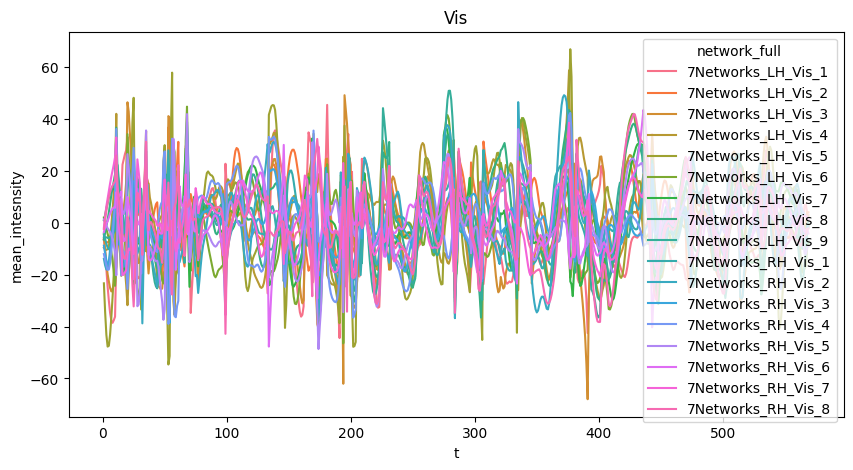

SomMot


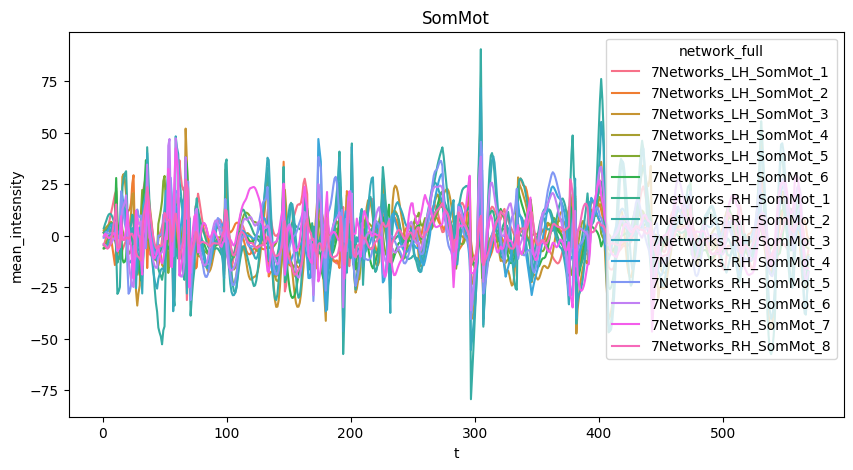

DorsAttn_Post


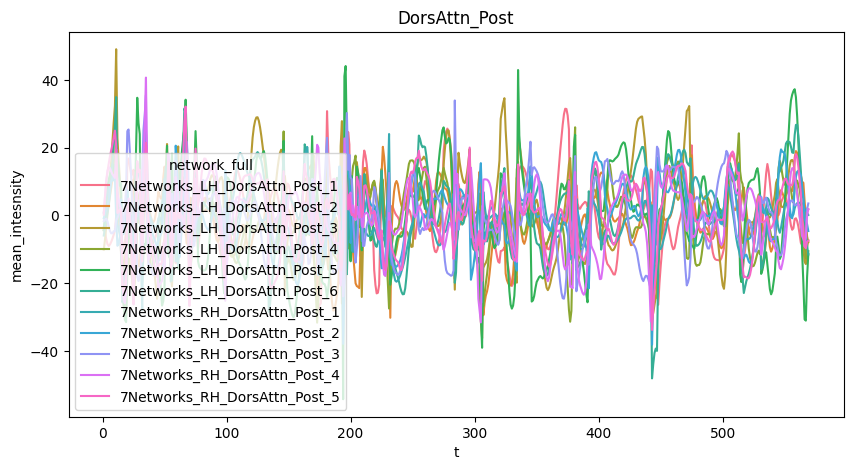

DorsAttn_FEF


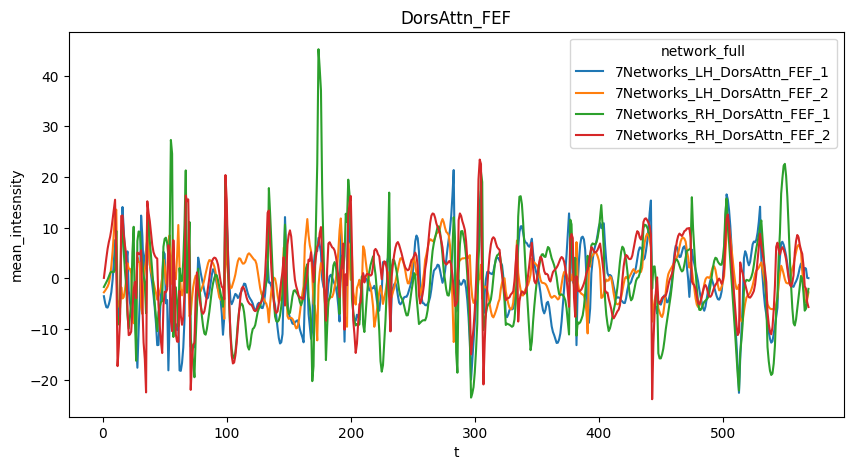

SalVentAttn_ParOper


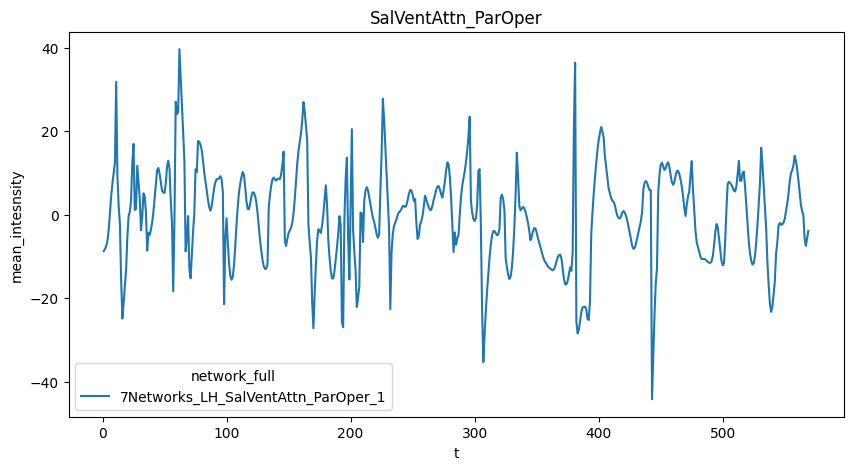

SalVentAttn_FrOper


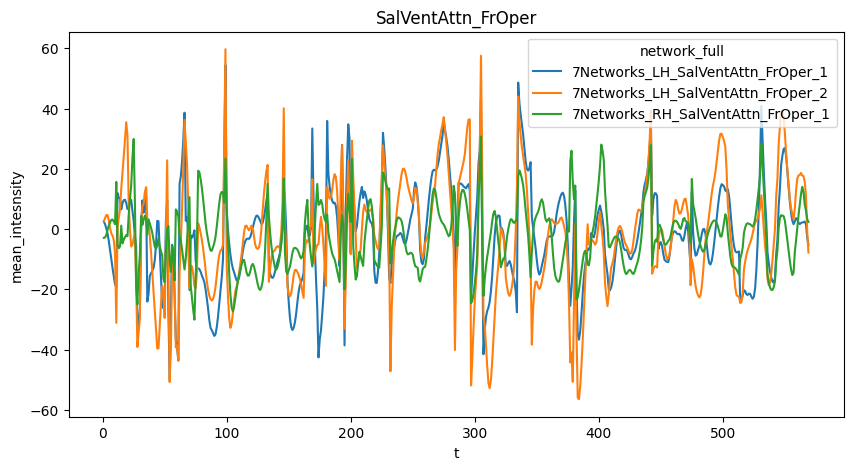

SalVentAttn_PFCl


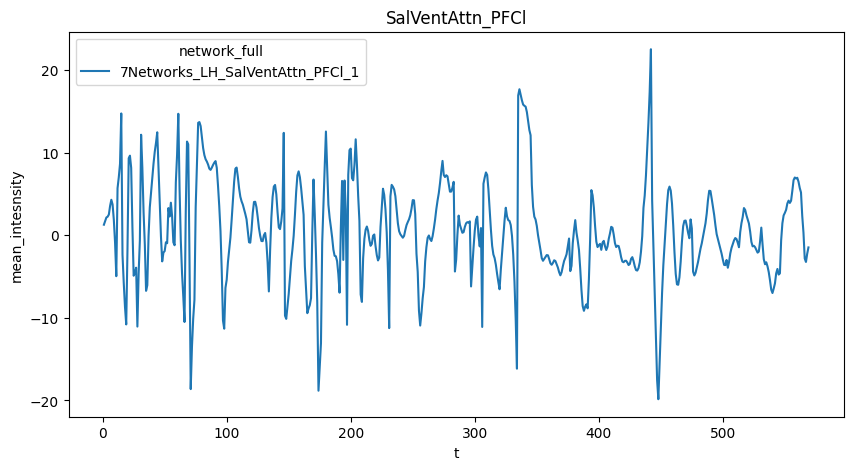

SalVentAttn_Med


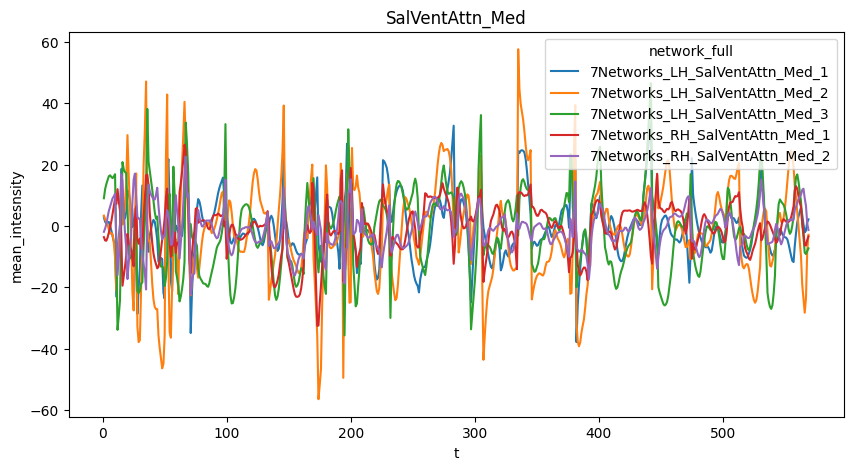

Limbic_OFC


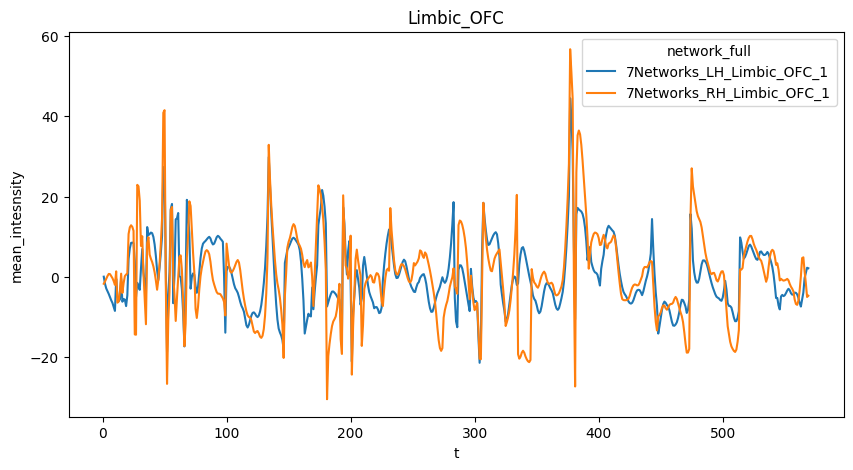

Limbic_TempPole


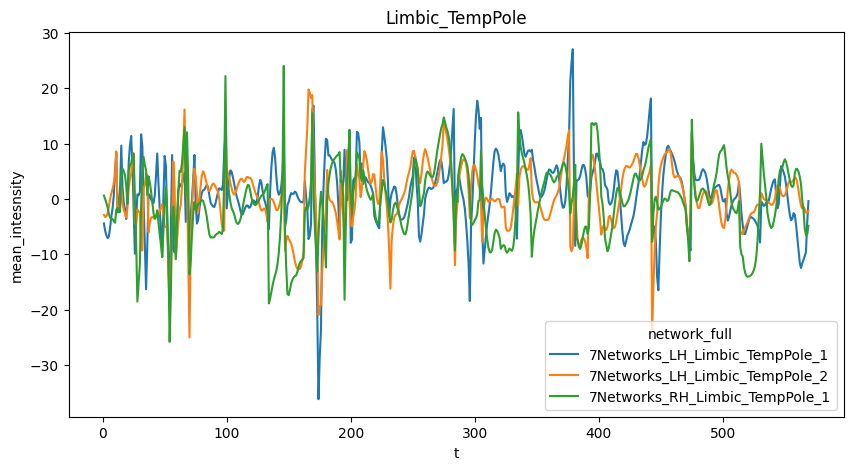

Cont_Par


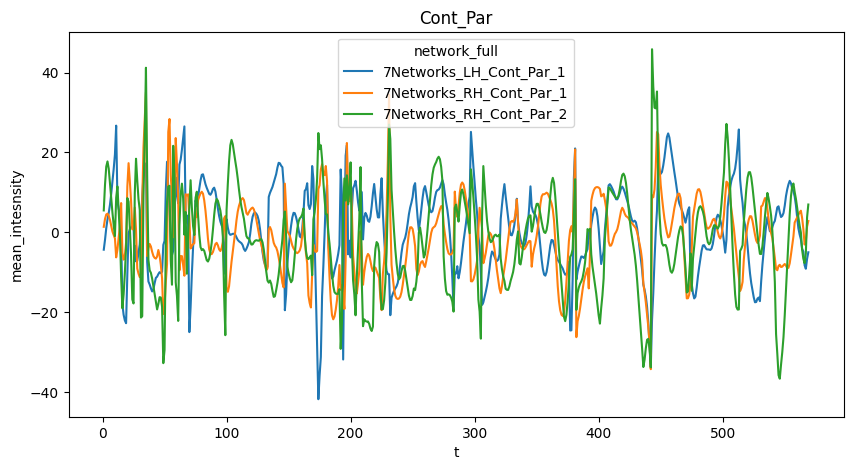

Cont_PFCl


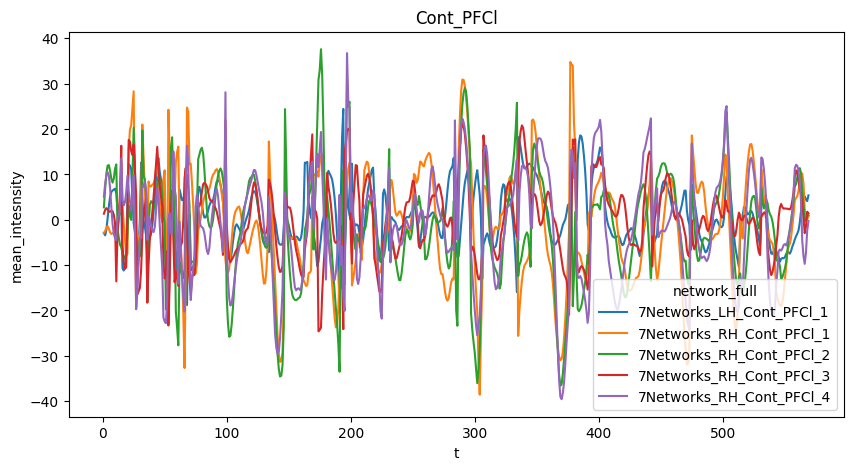

Cont_pCun


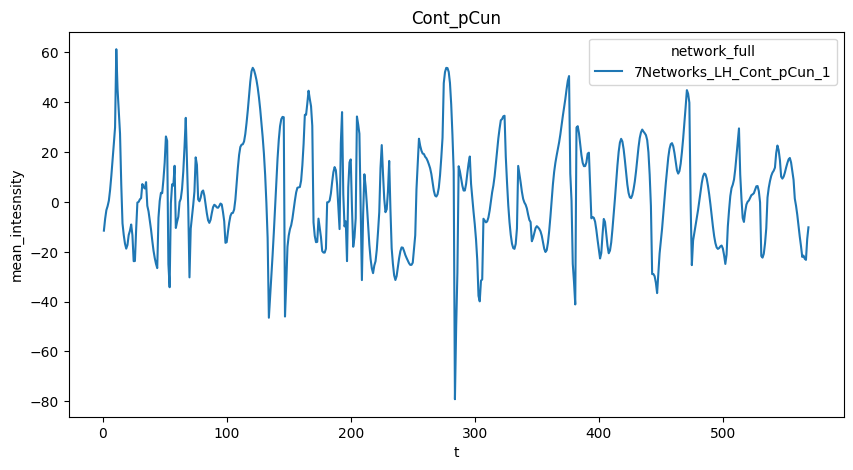

Cont_Cing


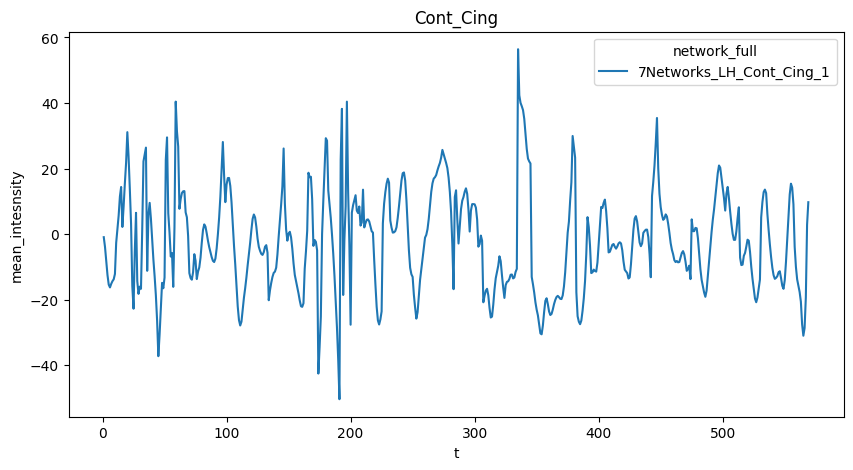

Default_Temp


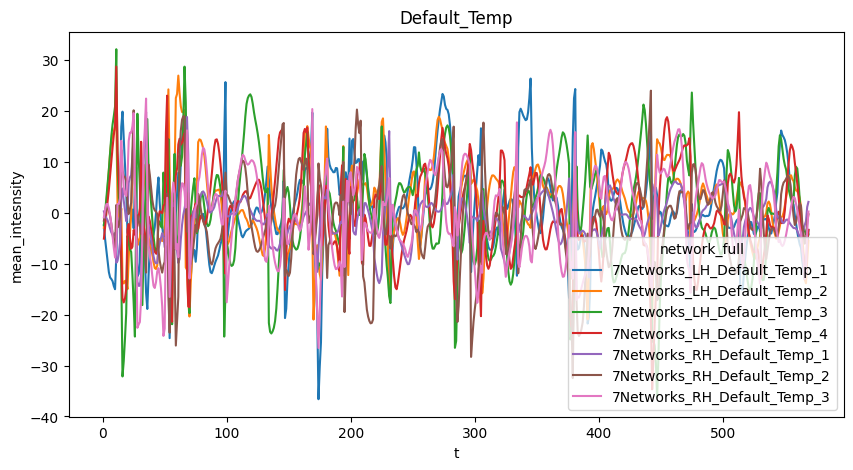

Default_PFC


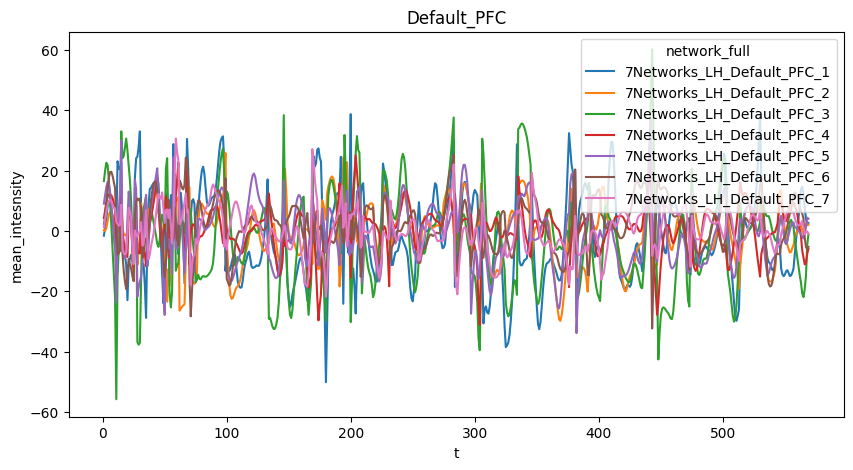

Default_PCC


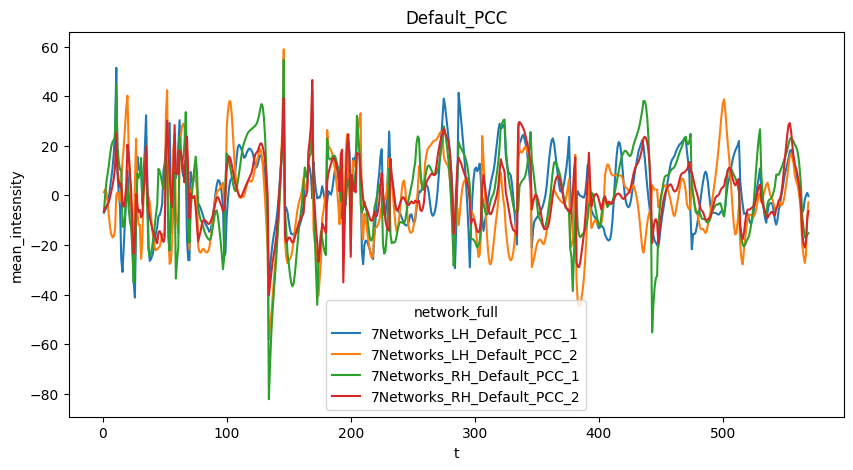

SalVentAttn_TempOccPar


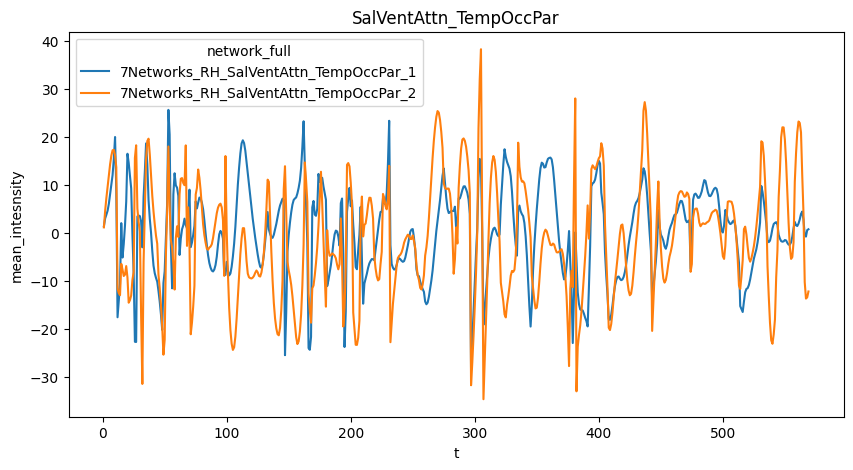

Cont_PFCmp


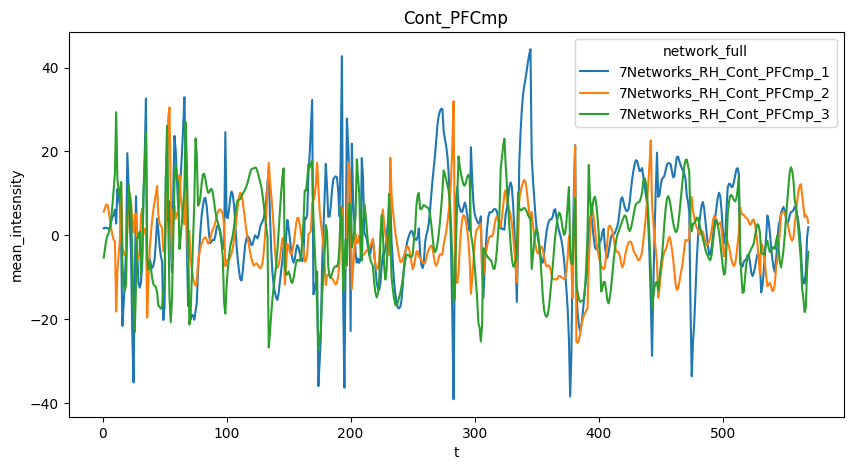

Default_Par


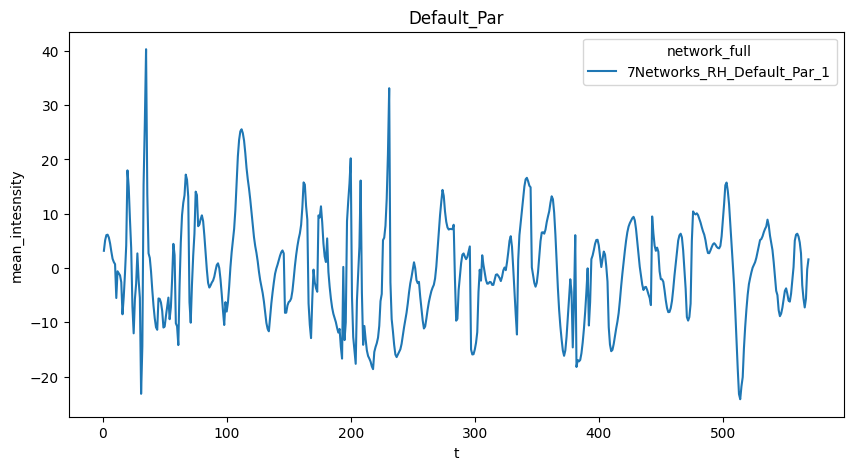

Default_PFCv


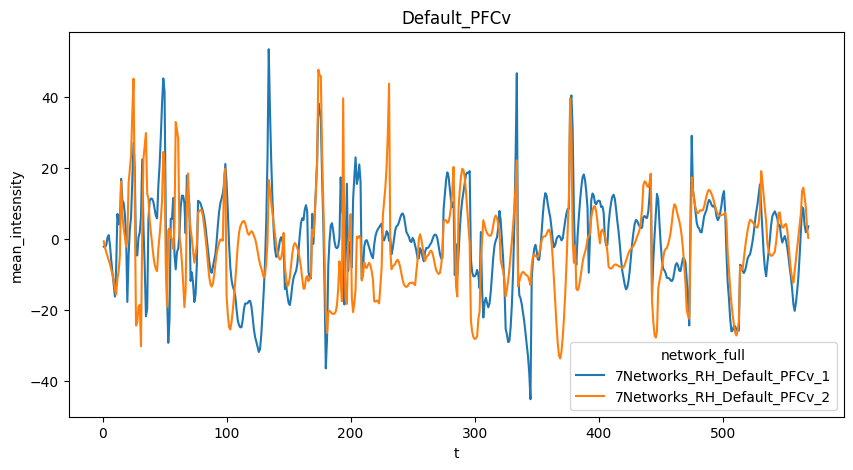

Default_PFCm


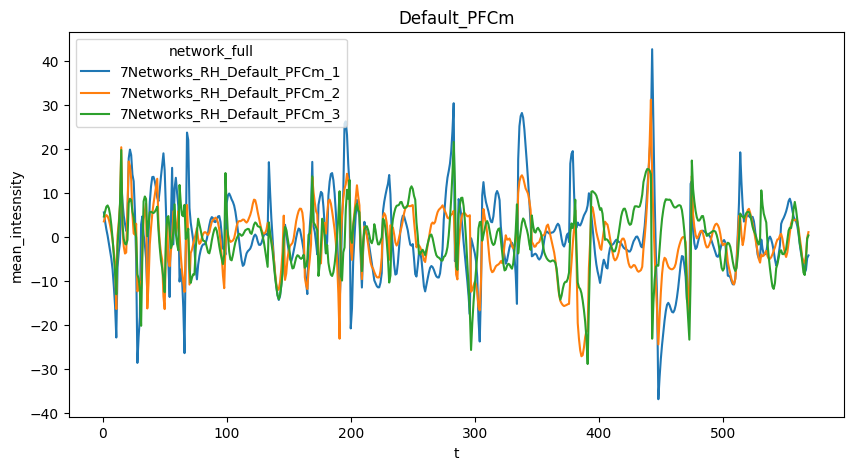

In [43]:
network_labels = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order.txt', sep='\t', names=['network_label', 'network_full', 'x', 'y', 'z', 't'])

mean_intensities = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order_mean_intensity_timeseries.csv')
mean_intensities.mean_intensity_timeseries = mean_intensities.mean_intensity_timeseries.apply(lambda x: x.strip('[]').split())
mean_intensities = pd.merge(network_labels[['network_label','network_full']], mean_intensities, on='network_label')

labels = mean_intensities.network_full.str.split('_')#.str[1:-1].str.join('_')
mean_intensities['side'] = labels.str[1]
mean_intensities['network'] = labels.str[2:-1].str.join('_')
mean_intensities['number'] = labels.str[-1]

for network in mean_intensities.network.unique():
    print(network)
    # Plot the mean intensity timeseries for each network
    plt.figure(figsize=(10, 5))

    network_intensities = mean_intensities[mean_intensities.network == network]
    network_intensities = network_intensities.explode('mean_intensity_timeseries')
    network_intensities['mean_intesnsity'] = network_intensities.mean_intensity_timeseries.astype(float)
    network_intensities['t'] = network_intensities.groupby('network_full').cumcount() + 1

    sns.lineplot(data=network_intensities, x='t', y='mean_intesnsity', hue='network_full')
    plt.title(network)
    plt.show()


(100, 569)
(100, 100)


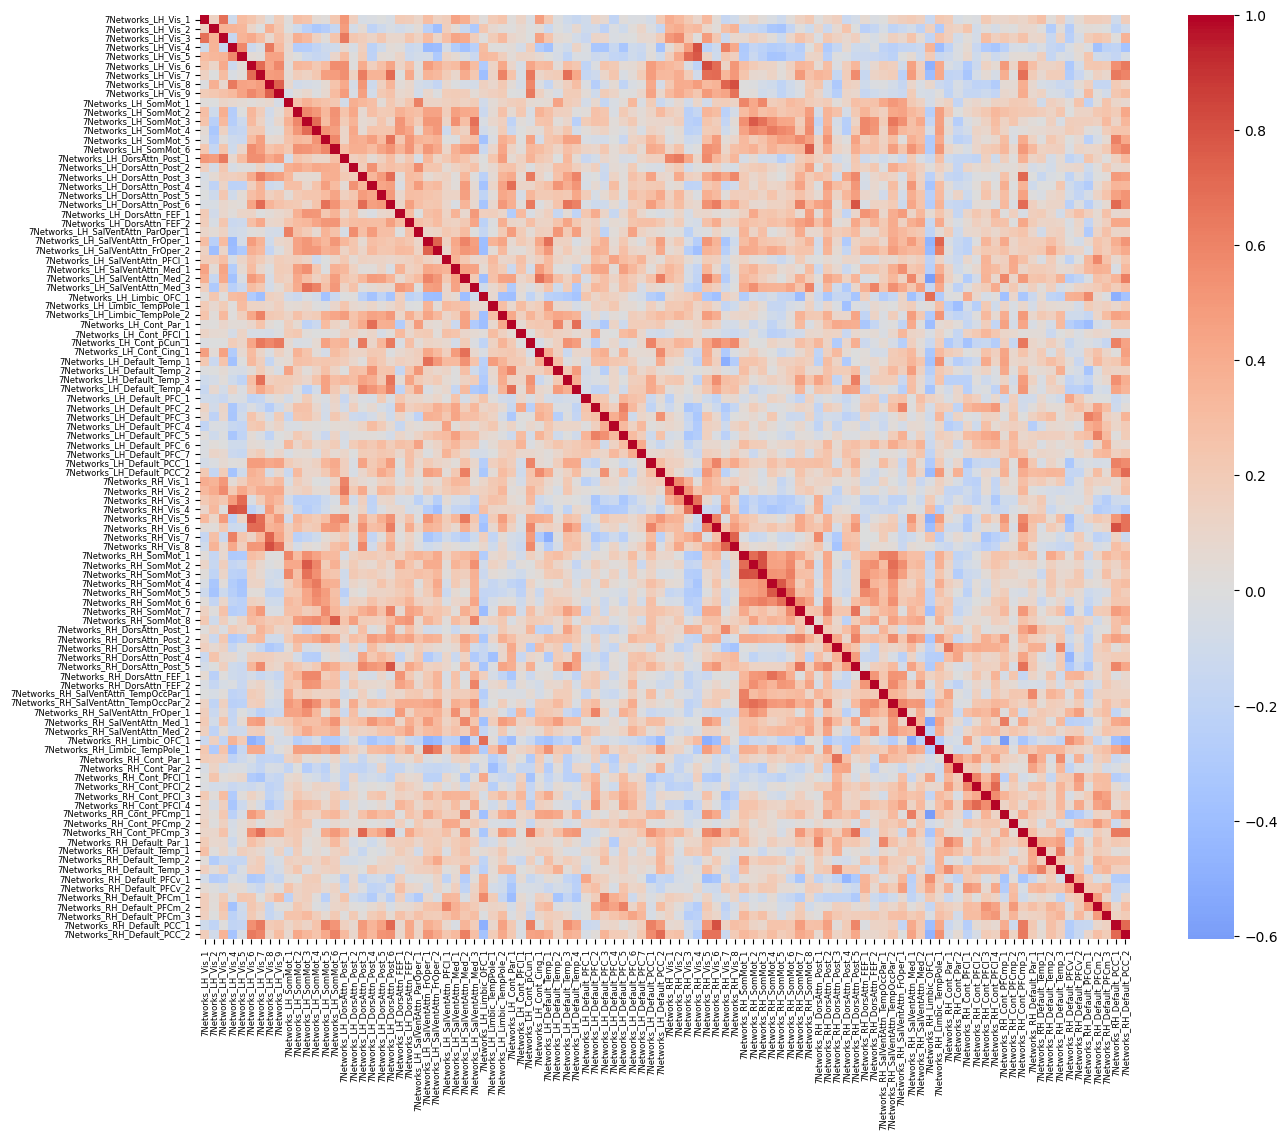

In [106]:
mean_intensities_arr = np.array(mean_intensities.mean_intensity_timeseries.tolist()).astype(float)
print(mean_intensities_arr.shape)

corr_matrix = np.corrcoef(mean_intensities_arr)
print(corr_matrix.shape)
# print(corr_matrix)


plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, xticklabels=mean_intensities.network_full, yticklabels=mean_intensities.network_full, cmap='coolwarm', center=0)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()


In [107]:
mean_intensity_timeseries_df

network                          mean_intensity_timeseries
0         1  [-6.249080329437824, -11.285741893706843, -17....
1         2  [-6.455303812301582, -7.288034929086604, -7.59...
2         3  [-4.558862374626213, -10.481233219373017, -15....
3         4  [-9.6135920473612, -10.214270263785167, -10.45...
4         5  [-23.34584366900708, -34.43465891379857, -43.2...
..      ...                                                ...
95       96  [5.616195020108553, 3.4715164403404133, 1.7509...
96       97  [3.578695691651405, 4.529882774691005, 5.01391...
97       98  [4.687908891937039, 5.864316840444395, 6.91889...
98       99  [-6.671410593231947, -0.2026899687407273, 5.32...
99      100  [-6.388479573103085, -5.173981400434871, -4.43...

[100 rows x 2 columns]